<a href="https://colab.research.google.com/github/judy0711/CoT_prompt_analysis/blob/main/lab_experiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Server address : `https://fb90-165-132-144-84.ngrok-free.app`
- Endpoints:
    - `/api/inference`: For calling API to generate outputs from LMs
    - `/api/change_password`: Change your password. Arguments: `student_id`, `old_password`, `new_password`.

- Check your remaining credit at this page.[https://fb90-165-132-144-84.ngrok-free.app/student_credits]

### Before we get started, let's change the password!

In [1]:
import requests
import os

server_address = "https://cot.ngrok.app"
data = {
    "student_id": "20221490##",
    "old_password": "######",
    "new_password": "######"
}
response = requests.post(f'{server_address}/api/change_password', json=data)

#Haha50158
#Hahaha50158

# Check if the request was successful
if response.status_code == 200:
    # Set the new password as an environment variable
    os.environ["INTRO_AI_API_KEY"] = data["new_password"]
    print("Environment variable INTRO_AI_API_KEY set successfully.")
else:
    print("Failed to change password. Status code:", response.status_code)

Environment variable INTRO_AI_API_KEY set successfully.


In [2]:
class LLM:
    def __init__(self, model_name, student_id, password):
        self.student_id = student_id
        self.password = password
        server_address = "https://cot.ngrok.app"
        self.api_url = f'{server_address}/api/inference'  # Replace with your server address
        self.model_name = model_name

    def generate(self, model_input, max_tokens=100, top_p=1.0, temperature=0.7, frequency_penalty=0, stop="\n\n"):
        data = {
            'model_name': self.model_name,
            'model_input': model_input,
            'student_id': self.student_id,
            'password': self.password,
            'max_tokens': max_tokens,
            'top_p': top_p,
            'temperature': temperature,
            'frequency_penalty': frequency_penalty,
            'stop': stop
        }
        response = requests.post(self.api_url, json=data)

        if response.status_code == 200:
            return response.json()  # Assuming the server returns a JSON response
        else:
            return f"Error: {response.text}"

In [3]:
student_id = "2022149013"
password = os.environ['INTRO_AI_API_KEY']

available_models = [
    "meta-llama/Llama-2-7b-hf",
    "facebook/opt-350m",
    "facebook/opt-1.3b",
    "facebook/opt-2.7b"
]
opt = LLM(available_models[1], student_id, password)

### Generate your first output by calling the API

In [4]:
model_input = "Hello World!"
result = opt.generate([model_input], stop=None)

In [5]:
print(result)

{'generations': [{'generation_info': {'finish_reason': 'length', 'logprobs': None}, 'text': " I'm a beginner and I have some questions about the game: 1) if you get a level 10 beast/dragon, do you actually get to level 10? 2) does the level 10 beast/dragon become level 1? 3) do the beasts that are level 10 or not affect the level 10 beast/dragon? 4) does the level 10 beast/dragon end up leveling up to level 10?\nI believe you get level 10 for every level 10 beast/dragon you encounter."}], 'llm_output': {'model_name': 'facebook/opt-350m', 'token_usage': {'completion_tokens': 100, 'prompt_tokens': 4, 'total_tokens': 104}}, 'run_info': [{'run_id': 'ed13ec7b-7301-4ed7-ab5f-8a3e7824e009'}]}


### Load GSM8K dataset

In [6]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00


In [7]:
from datasets import load_dataset

gsm8k = load_dataset("gsm8k", "main")['test']



Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

### An example from GSM8k

In [8]:
print("Question:")
print(gsm8k['question'][0])
print("="*100)
print("Answer:")
print(gsm8k['answer'][0])

Question:
Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
Answer:
Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.
She makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.
#### 18


# Self Experiment 1 Zero Shot Prompting vs. Few Shot Prompting (Standard) No CoT (Instruction) included

In [9]:
import random
random.seed(0)

def construct_prompt(num_exemplars):
    # Load train set of GSM8K
    gsm8k = load_dataset("gsm8k", "main")['train']

    sampled_indices = random.sample([i for i in range(len(gsm8k['question']))], num_exemplars)


    instruction = "Instruction:\nSolve the following mathematical question and generate the answer after a tag, 'Answer:'. "
    # Constructing a prompt with few-shot demonstrations from GSM8K
    prompt = instruction
    if num_exemplars == 0:
        cur_question = gsm8k['question'][0]
        cur_answer = gsm8k['answer'][0].split("####")[-1].strip()
        prompt += "\nQuestion: \n {question}\nAnswer:"
    else:
      for i in range(num_exemplars):
          cur_question = gsm8k['question'][i]
          cur_answer = gsm8k['answer'][i].split("####")[-1].strip()
          prompt += f"\n[Example {i+1}]\n"
          prompt += f"Question:\n{cur_question}\n"
          prompt += f"Answer:\n{cur_answer}\n"
      prompt += "\nQuestion:\n{question}\nAnswer:"


    # Write the prompt to a .txt file
    with open(f"standard_prompt_{num_exemplars}shot.txt", "w") as f:
        f.write(prompt)


In [10]:
construct_prompt(0)
construct_prompt(3)
construct_prompt(5)

In [11]:
with open("standard_prompt_0shot.txt", "r") as f:
    prompt_0shot = f.read()


from tqdm import tqdm
import json

llama = LLM("meta-llama/Llama-2-7b-hf", student_id, password)
results_collected = []
pass_collected = []
for i in tqdm(range(50)):
    cur_question = gsm8k['question'][i]
    cur_anwer = gsm8k['answer'][i].split("####")[-1].strip()
    cur_model_input = prompt_0shot.format(question=cur_question)
    result = llama.generate([cur_model_input], stop=["\n\n", "[Example 2]"])
    if "Error:" in result:
        print(result)
        break
    cur_prediction = result['generations'][0]['text']
    # print(cur_prediction)

    pass_collected.append(cur_prediction.strip().replace("$", "0") == cur_anwer)
    results_collected.append({"question": cur_question, "answer": cur_anwer, "prediction": cur_prediction})
    print(f"Acc: {sum(pass_collected)/ len(pass_collected)}")

with open("exp1_result_0shot_direct.json", "w") as f:
    json.dump(results_collected, f, indent=4)

  2%|▏         | 1/50 [00:00<00:29,  1.63it/s]

Acc: 0.0


  4%|▍         | 2/50 [00:01<00:29,  1.64it/s]

Acc: 0.0


  6%|▌         | 3/50 [00:02<00:32,  1.45it/s]

Acc: 0.0


  8%|▊         | 4/50 [00:02<00:29,  1.55it/s]

Acc: 0.0


 10%|█         | 5/50 [00:03<00:30,  1.47it/s]

Acc: 0.0


 12%|█▏        | 6/50 [00:04<00:33,  1.31it/s]

Acc: 0.0


 14%|█▍        | 7/50 [00:05<00:35,  1.23it/s]

Acc: 0.0


 16%|█▌        | 8/50 [00:06<00:38,  1.10it/s]

Acc: 0.0


 18%|█▊        | 9/50 [00:07<00:43,  1.07s/it]

Acc: 0.0


 20%|██        | 10/50 [00:08<00:40,  1.01s/it]

Acc: 0.0


 22%|██▏       | 11/50 [00:09<00:38,  1.00it/s]

Acc: 0.0


 24%|██▍       | 12/50 [00:12<01:05,  1.73s/it]

Acc: 0.0


 26%|██▌       | 13/50 [00:13<00:53,  1.46s/it]

Acc: 0.0


 28%|██▊       | 14/50 [00:14<00:46,  1.28s/it]

Acc: 0.0


 30%|███       | 15/50 [00:15<00:39,  1.12s/it]

Acc: 0.0


 32%|███▏      | 16/50 [00:16<00:34,  1.02s/it]

Acc: 0.0


 34%|███▍      | 17/50 [00:17<00:32,  1.01it/s]

Acc: 0.0


 36%|███▌      | 18/50 [00:17<00:29,  1.10it/s]

Acc: 0.0


 38%|███▊      | 19/50 [00:18<00:24,  1.24it/s]

Acc: 0.0


 40%|████      | 20/50 [00:19<00:26,  1.13it/s]

Acc: 0.0


 42%|████▏     | 21/50 [00:20<00:23,  1.22it/s]

Acc: 0.0


 44%|████▍     | 22/50 [00:20<00:21,  1.29it/s]

Acc: 0.0


 46%|████▌     | 23/50 [00:24<00:43,  1.60s/it]

Acc: 0.0


 48%|████▊     | 24/50 [00:25<00:35,  1.37s/it]

Acc: 0.0


 50%|█████     | 25/50 [00:25<00:28,  1.15s/it]

Acc: 0.0


 52%|█████▏    | 26/50 [00:26<00:23,  1.01it/s]

Acc: 0.0


 54%|█████▍    | 27/50 [00:27<00:20,  1.15it/s]

Acc: 0.0


 56%|█████▌    | 28/50 [00:27<00:17,  1.26it/s]

Acc: 0.0


 58%|█████▊    | 29/50 [00:28<00:15,  1.36it/s]

Acc: 0.0


 60%|██████    | 30/50 [00:28<00:14,  1.42it/s]

Acc: 0.0


 62%|██████▏   | 31/50 [00:29<00:13,  1.45it/s]

Acc: 0.0


 64%|██████▍   | 32/50 [00:30<00:11,  1.50it/s]

Acc: 0.0


 66%|██████▌   | 33/50 [00:30<00:10,  1.55it/s]

Acc: 0.0


 68%|██████▊   | 34/50 [00:31<00:09,  1.62it/s]

Acc: 0.0


 70%|███████   | 35/50 [00:31<00:09,  1.63it/s]

Acc: 0.0


 72%|███████▏  | 36/50 [00:32<00:08,  1.59it/s]

Acc: 0.0


 74%|███████▍  | 37/50 [00:33<00:08,  1.56it/s]

Acc: 0.0


 76%|███████▌  | 38/50 [00:33<00:07,  1.53it/s]

Acc: 0.0


 78%|███████▊  | 39/50 [00:34<00:07,  1.52it/s]

Acc: 0.0


 80%|████████  | 40/50 [00:35<00:06,  1.55it/s]

Acc: 0.0


 82%|████████▏ | 41/50 [00:35<00:05,  1.52it/s]

Acc: 0.0


 84%|████████▍ | 42/50 [00:36<00:05,  1.54it/s]

Acc: 0.0


 86%|████████▌ | 43/50 [00:37<00:05,  1.28it/s]

Acc: 0.0


 88%|████████▊ | 44/50 [00:38<00:04,  1.38it/s]

Acc: 0.0


 90%|█████████ | 45/50 [00:38<00:03,  1.44it/s]

Acc: 0.0


 92%|█████████▏| 46/50 [00:39<00:02,  1.49it/s]

Acc: 0.0


 94%|█████████▍| 47/50 [00:40<00:01,  1.53it/s]

Acc: 0.0


 96%|█████████▌| 48/50 [00:42<00:02,  1.29s/it]

Acc: 0.0


 98%|█████████▊| 49/50 [00:43<00:01,  1.08s/it]

Acc: 0.0


100%|██████████| 50/50 [00:44<00:00,  1.14it/s]

Acc: 0.0


In [12]:
with open("standard_prompt_3shot.txt", "r") as f:
    prompt_0shot = f.read()


from tqdm import tqdm
import json

llama = LLM("meta-llama/Llama-2-7b-hf", student_id, password)
results_collected = []
pass_collected = []
for i in tqdm(range(50)):
    cur_question = gsm8k['question'][i]
    cur_anwer = gsm8k['answer'][i].split("####")[-1].strip()
    cur_model_input = prompt_0shot.format(question=cur_question)
    result = llama.generate([cur_model_input], stop=["\n\n", "[Example 2]"])
    if "Error:" in result:
        print(result)
        break
    cur_prediction = result['generations'][0]['text']
    # print(cur_prediction)

    pass_collected.append(cur_prediction.strip().replace("$", "0") == cur_anwer)
    results_collected.append({"question": cur_question, "answer": cur_anwer, "prediction": cur_prediction})
    print(f"Acc: {sum(pass_collected)/ len(pass_collected)}")

with open("exp1_result_3shot_direct.json", "w") as f:
    json.dump(results_collected, f, indent=4)

  2%|▏         | 1/50 [00:00<00:44,  1.11it/s]

Acc: 1.0


  4%|▍         | 2/50 [00:01<00:37,  1.28it/s]

Acc: 0.5


  6%|▌         | 3/50 [00:02<00:39,  1.20it/s]

Acc: 0.3333333333333333


  8%|▊         | 4/50 [00:03<00:37,  1.21it/s]

Acc: 0.25


 10%|█         | 5/50 [00:04<00:37,  1.21it/s]

Acc: 0.4


 12%|█▏        | 6/50 [00:04<00:35,  1.24it/s]

Acc: 0.5


 14%|█▍        | 7/50 [00:05<00:34,  1.25it/s]

Acc: 0.42857142857142855


 16%|█▌        | 8/50 [00:06<00:33,  1.24it/s]

Acc: 0.375


 18%|█▊        | 9/50 [00:07<00:33,  1.22it/s]

Acc: 0.3333333333333333


 20%|██        | 10/50 [00:08<00:32,  1.23it/s]

Acc: 0.3


 22%|██▏       | 11/50 [00:08<00:30,  1.27it/s]

Acc: 0.2727272727272727


 24%|██▍       | 12/50 [00:09<00:30,  1.24it/s]

Acc: 0.25


 26%|██▌       | 13/50 [00:10<00:29,  1.24it/s]

Acc: 0.23076923076923078


 28%|██▊       | 14/50 [00:11<00:28,  1.28it/s]

Acc: 0.21428571428571427


 30%|███       | 15/50 [00:12<00:29,  1.20it/s]

Acc: 0.2


 32%|███▏      | 16/50 [00:13<00:28,  1.20it/s]

Acc: 0.1875


 34%|███▍      | 17/50 [00:13<00:27,  1.20it/s]

Acc: 0.17647058823529413


 36%|███▌      | 18/50 [00:14<00:27,  1.15it/s]

Acc: 0.16666666666666666


 38%|███▊      | 19/50 [00:15<00:26,  1.18it/s]

Acc: 0.15789473684210525


 40%|████      | 20/50 [00:16<00:25,  1.18it/s]

Acc: 0.15


 42%|████▏     | 21/50 [00:17<00:24,  1.17it/s]

Acc: 0.14285714285714285


 44%|████▍     | 22/50 [00:18<00:23,  1.20it/s]

Acc: 0.13636363636363635


 46%|████▌     | 23/50 [00:19<00:23,  1.14it/s]

Acc: 0.13043478260869565


 48%|████▊     | 24/50 [00:19<00:21,  1.21it/s]

Acc: 0.125


 50%|█████     | 25/50 [00:20<00:20,  1.19it/s]

Acc: 0.12


 52%|█████▏    | 26/50 [00:21<00:18,  1.28it/s]

Acc: 0.11538461538461539


 54%|█████▍    | 27/50 [00:22<00:18,  1.24it/s]

Acc: 0.1111111111111111


 56%|█████▌    | 28/50 [00:23<00:18,  1.16it/s]

Acc: 0.10714285714285714


 58%|█████▊    | 29/50 [00:23<00:17,  1.21it/s]

Acc: 0.10344827586206896


 60%|██████    | 30/50 [00:24<00:16,  1.23it/s]

Acc: 0.1


 62%|██████▏   | 31/50 [00:26<00:19,  1.05s/it]

Acc: 0.0967741935483871


 64%|██████▍   | 32/50 [00:27<00:17,  1.04it/s]

Acc: 0.09375


 66%|██████▌   | 33/50 [00:27<00:15,  1.08it/s]

Acc: 0.09090909090909091


 68%|██████▊   | 34/50 [00:28<00:14,  1.11it/s]

Acc: 0.08823529411764706


 70%|███████   | 35/50 [00:29<00:13,  1.15it/s]

Acc: 0.08571428571428572


 72%|███████▏  | 36/50 [00:30<00:11,  1.20it/s]

Acc: 0.08333333333333333


 74%|███████▍  | 37/50 [00:31<00:10,  1.20it/s]

Acc: 0.08108108108108109


 76%|███████▌  | 38/50 [00:31<00:09,  1.26it/s]

Acc: 0.07894736842105263


 78%|███████▊  | 39/50 [00:32<00:08,  1.23it/s]

Acc: 0.07692307692307693


 80%|████████  | 40/50 [00:33<00:08,  1.25it/s]

Acc: 0.075


 82%|████████▏ | 41/50 [00:34<00:07,  1.27it/s]

Acc: 0.07317073170731707


 84%|████████▍ | 42/50 [00:35<00:06,  1.20it/s]

Acc: 0.07142857142857142


 86%|████████▌ | 43/50 [00:36<00:05,  1.18it/s]

Acc: 0.06976744186046512


 88%|████████▊ | 44/50 [00:36<00:05,  1.16it/s]

Acc: 0.06818181818181818


 90%|█████████ | 45/50 [00:38<00:04,  1.05it/s]

Acc: 0.06666666666666667


 92%|█████████▏| 46/50 [00:38<00:03,  1.10it/s]

Acc: 0.06521739130434782


 94%|█████████▍| 47/50 [00:39<00:02,  1.11it/s]

Acc: 0.06382978723404255


 96%|█████████▌| 48/50 [00:40<00:01,  1.02it/s]

Acc: 0.0625


 98%|█████████▊| 49/50 [00:41<00:00,  1.06it/s]

Acc: 0.061224489795918366


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]

Acc: 0.06


In [13]:
with open("standard_prompt_5shot.txt", "r") as f:
    standard_prompt_5shot = f.read()


from tqdm import tqdm
import json

llama = LLM("meta-llama/Llama-2-7b-hf", student_id, password)
results_collected = []
pass_collected = []
for i in tqdm(range(50)):
    cur_question = gsm8k['question'][i]
    cur_anwer = gsm8k['answer'][i].split("####")[-1].strip()
    cur_model_input = standard_prompt_5shot.format(question=cur_question)
    result = llama.generate([cur_model_input], stop=["\n\n", "[Example 2]"])
    if "Error:" in result:
        print(result)
        break
    cur_prediction = result['generations'][0]['text']
    # print(cur_prediction)

    pass_collected.append(cur_prediction.strip().replace("$", "0") == cur_anwer)
    results_collected.append({"question": cur_question, "answer": cur_anwer, "prediction": cur_prediction})
    print(f"Acc: {sum(pass_collected)/ len(pass_collected)}")

with open("exp1_result_5shot_direct.json", "w") as f:
    json.dump(results_collected, f, indent=4)

  2%|▏         | 1/50 [00:01<00:49,  1.00s/it]

Acc: 0.0


  4%|▍         | 2/50 [00:01<00:40,  1.18it/s]

Acc: 0.5


  6%|▌         | 3/50 [00:02<00:47,  1.02s/it]

Acc: 0.3333333333333333


  8%|▊         | 4/50 [00:03<00:44,  1.03it/s]

Acc: 0.25


 10%|█         | 5/50 [00:04<00:43,  1.04it/s]

Acc: 0.2


 12%|█▏        | 6/50 [00:05<00:40,  1.09it/s]

Acc: 0.16666666666666666


 14%|█▍        | 7/50 [00:06<00:39,  1.09it/s]

Acc: 0.14285714285714285


 16%|█▌        | 8/50 [00:07<00:39,  1.06it/s]

Acc: 0.125


 18%|█▊        | 9/50 [00:08<00:37,  1.09it/s]

Acc: 0.1111111111111111


 20%|██        | 10/50 [00:09<00:37,  1.06it/s]

Acc: 0.1


 22%|██▏       | 11/50 [00:10<00:35,  1.11it/s]

Acc: 0.09090909090909091


 24%|██▍       | 12/50 [00:11<00:40,  1.06s/it]

Acc: 0.08333333333333333


 26%|██▌       | 13/50 [00:12<00:37,  1.03s/it]

Acc: 0.07692307692307693


 28%|██▊       | 14/50 [00:13<00:36,  1.02s/it]

Acc: 0.07142857142857142


 30%|███       | 15/50 [00:14<00:34,  1.00it/s]

Acc: 0.06666666666666667


 32%|███▏      | 16/50 [00:15<00:33,  1.01it/s]

Acc: 0.0625


 34%|███▍      | 17/50 [00:16<00:34,  1.05s/it]

Acc: 0.058823529411764705


 36%|███▌      | 18/50 [00:17<00:32,  1.01s/it]

Acc: 0.05555555555555555


 38%|███▊      | 19/50 [00:18<00:30,  1.02it/s]

Acc: 0.05263157894736842


 40%|████      | 20/50 [00:19<00:28,  1.06it/s]

Acc: 0.05


 42%|████▏     | 21/50 [00:20<00:27,  1.06it/s]

Acc: 0.047619047619047616


 44%|████▍     | 22/50 [00:21<00:26,  1.05it/s]

Acc: 0.045454545454545456


 46%|████▌     | 23/50 [00:22<00:24,  1.11it/s]

Acc: 0.043478260869565216


 48%|████▊     | 24/50 [00:23<00:23,  1.09it/s]

Acc: 0.041666666666666664


 50%|█████     | 25/50 [00:23<00:23,  1.07it/s]

Acc: 0.04


 52%|█████▏    | 26/50 [00:24<00:21,  1.11it/s]

Acc: 0.038461538461538464


 54%|█████▍    | 27/50 [00:25<00:20,  1.12it/s]

Acc: 0.037037037037037035


 56%|█████▌    | 28/50 [00:26<00:19,  1.11it/s]

Acc: 0.03571428571428571


 58%|█████▊    | 29/50 [00:27<00:18,  1.15it/s]

Acc: 0.034482758620689655


 60%|██████    | 30/50 [00:28<00:17,  1.17it/s]

Acc: 0.03333333333333333


 62%|██████▏   | 31/50 [00:29<00:17,  1.12it/s]

Acc: 0.03225806451612903


 64%|██████▍   | 32/50 [00:30<00:15,  1.16it/s]

Acc: 0.03125


 66%|██████▌   | 33/50 [00:30<00:14,  1.18it/s]

Acc: 0.030303030303030304


 68%|██████▊   | 34/50 [00:31<00:13,  1.21it/s]

Acc: 0.029411764705882353


 70%|███████   | 35/50 [00:32<00:12,  1.23it/s]

Acc: 0.02857142857142857


 72%|███████▏  | 36/50 [00:33<00:12,  1.15it/s]

Acc: 0.027777777777777776


 74%|███████▍  | 37/50 [00:34<00:11,  1.14it/s]

Acc: 0.02702702702702703


 76%|███████▌  | 38/50 [00:34<00:09,  1.21it/s]

Acc: 0.02631578947368421


 78%|███████▊  | 39/50 [00:35<00:09,  1.21it/s]

Acc: 0.02564102564102564


 80%|████████  | 40/50 [00:36<00:08,  1.20it/s]

Acc: 0.025


 82%|████████▏ | 41/50 [00:37<00:07,  1.19it/s]

Acc: 0.024390243902439025


 84%|████████▍ | 42/50 [00:38<00:06,  1.17it/s]

Acc: 0.023809523809523808


 86%|████████▌ | 43/50 [00:39<00:05,  1.17it/s]

Acc: 0.023255813953488372


 88%|████████▊ | 44/50 [00:40<00:05,  1.12it/s]

Acc: 0.022727272727272728


 90%|█████████ | 45/50 [00:41<00:04,  1.06it/s]

Acc: 0.022222222222222223


 92%|█████████▏| 46/50 [00:42<00:04,  1.02s/it]

Acc: 0.021739130434782608


 94%|█████████▍| 47/50 [00:43<00:02,  1.04it/s]

Acc: 0.02127659574468085


 96%|█████████▌| 48/50 [00:44<00:01,  1.05it/s]

Acc: 0.020833333333333332


 98%|█████████▊| 49/50 [00:44<00:00,  1.13it/s]

Acc: 0.02040816326530612


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]

Acc: 0.02


# Self Experiment 2 Zero Shot Prompting vs. Few Shot Prompting (CoT (Instruction) included)

In [14]:
import re

In [15]:
from datasets import load_dataset

gsm8k = load_dataset("gsm8k", "main")['test']

print("Question:")
print(gsm8k['question'][1])
print("="*100)
print("Answer:")
print(gsm8k['answer'][1])

Question:
A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it take?
Answer:
It takes 2/2=<<2/2=1>>1 bolt of white fiber
So the total amount of fabric is 2+1=<<2+1=3>>3 bolts of fabric
#### 3


In [16]:
import random
random.seed(0)

def construct_prompt(num_exemplars):
    # Load train set of GSM8K
    gsm8k = load_dataset("gsm8k", "main")['train']

    sampled_indices = random.sample([i for i in range(len(gsm8k['question']))], num_exemplars)


    instruction = "Instruction:\nSolve the following mathematical question. \nGive a step by step reasoning. \nGive the answer with the following format : 'The Answer is' answer. "
    # Constructing a prompt with few-shot demonstrations from GSM8K
    prompt = instruction
    if num_exemplars == 0:
        cur_question = gsm8k['question'][0]
        cur_answer = cur_answer = gsm8k['answer'][0].split('####')[0] + "The answer is " +gsm8k['answer'][0].split('####')[-1].strip()
        prompt += "\nQuestion: \n {question}\nAnswer:"
    else:
      for i in range(num_exemplars):
          cur_question = gsm8k['question'][i]
          cur_answer = gsm8k['answer'][i].split('####')[0] + "The answer is " + gsm8k['answer'][i].split('####')[-1].strip()
          prompt += f"\n[Example {i+1}]\n"
          prompt += f"Question:\n{cur_question}\n"
          prompt += f"Answer:\n{cur_answer}\n"
      prompt += "\nQuestion:\n{question}\nAnswer:"


    # Write the prompt to a .txt file
    with open(f"CoT_prompt_{num_exemplars}shot.txt", "w") as f:
        f.write(prompt)

In [17]:
construct_prompt(0)
construct_prompt(3)
construct_prompt(5)

In [18]:
print(gsm8k['answer'][0].split('####')[0] + "The answer is " + gsm8k['answer'][0].split('####')[-1].strip())

Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.
She makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.
The answer is 18


In [19]:
with open("CoT_prompt_0shot.txt", "r") as f:
    CoT_prompt_0shot = f.read()


from tqdm import tqdm
import json

llama = LLM("meta-llama/Llama-2-7b-hf", student_id, password)
results_collected = []
pass_collected = []
for i in tqdm(range(50)):
    cur_question = gsm8k['question'][i]
    cur_anwer = gsm8k['answer'][i].split("####")[-1].strip() #number answer
    cur_model_input = CoT_prompt_0shot.format(question=cur_question)
    result = llama.generate([cur_model_input], stop=["\n\n"])
    if "Error:" in result:
        print(result)
        break
    cur_prediction = result['generations'][0]['text']

    num_matches = re.findall(r'\d+\.\d+|\d+', cur_prediction)
    num_prediction = num_matches[-1] if num_matches else ""
    print(num_prediction)

    pass_collected.append(num_prediction == cur_anwer)
    results_collected.append({"question": cur_question, "answer": cur_anwer, "prediction": cur_prediction})
    print(f"Acc: {sum(pass_collected)/ len(pass_collected)}")

with open("exp2_result_0shot_direct.json", "w") as f:
    json.dump(results_collected, f, indent=4)

  2%|▏         | 1/50 [00:00<00:34,  1.41it/s]

32
Acc: 0.0


  4%|▍         | 2/50 [00:01<00:32,  1.49it/s]


Acc: 0.0


  6%|▌         | 3/50 [00:02<00:31,  1.50it/s]


Acc: 0.0


  8%|▊         | 4/50 [00:02<00:35,  1.29it/s]

210
Acc: 0.0


 10%|█         | 5/50 [00:03<00:32,  1.37it/s]


Acc: 0.0


 12%|█▏        | 6/50 [00:04<00:41,  1.06it/s]

12
Acc: 0.0


 14%|█▍        | 7/50 [00:05<00:38,  1.12it/s]


Acc: 0.0


 16%|█▌        | 8/50 [00:08<01:06,  1.59s/it]

18
Acc: 0.0


 18%|█▊        | 9/50 [00:09<00:52,  1.28s/it]


Acc: 0.0


 20%|██        | 10/50 [00:10<00:44,  1.12s/it]


Acc: 0.0


 22%|██▏       | 11/50 [00:10<00:37,  1.05it/s]


Acc: 0.0


 24%|██▍       | 12/50 [00:11<00:33,  1.14it/s]

293
Acc: 0.0


 26%|██▌       | 13/50 [00:12<00:29,  1.26it/s]


Acc: 0.0


 28%|██▊       | 14/50 [00:12<00:28,  1.24it/s]

15
Acc: 0.0


 30%|███       | 15/50 [00:13<00:30,  1.13it/s]

18
Acc: 0.0


 32%|███▏      | 16/50 [00:15<00:31,  1.07it/s]


Acc: 0.0


 34%|███▍      | 17/50 [00:15<00:30,  1.10it/s]


Acc: 0.0


 36%|███▌      | 18/50 [00:16<00:29,  1.09it/s]


Acc: 0.0


 38%|███▊      | 19/50 [00:17<00:29,  1.06it/s]


Acc: 0.0


 40%|████      | 20/50 [00:18<00:25,  1.17it/s]


Acc: 0.0


 42%|████▏     | 21/50 [00:19<00:22,  1.26it/s]


Acc: 0.0


 44%|████▍     | 22/50 [00:19<00:20,  1.35it/s]


Acc: 0.0


 46%|████▌     | 23/50 [00:20<00:18,  1.44it/s]


Acc: 0.0


 48%|████▊     | 24/50 [00:20<00:17,  1.50it/s]


Acc: 0.0


 50%|█████     | 25/50 [00:21<00:17,  1.44it/s]

25
Acc: 0.0


 52%|█████▏    | 26/50 [00:22<00:20,  1.19it/s]

00
Acc: 0.0


 54%|█████▍    | 27/50 [00:23<00:18,  1.21it/s]


Acc: 0.0


 56%|█████▌    | 28/50 [00:24<00:19,  1.14it/s]

240
Acc: 0.0


 58%|█████▊    | 29/50 [00:25<00:18,  1.14it/s]

20
Acc: 0.0


 60%|██████    | 30/50 [00:28<00:30,  1.53s/it]

1
Acc: 0.0


 62%|██████▏   | 31/50 [00:29<00:25,  1.34s/it]

13
Acc: 0.0


 64%|██████▍   | 32/50 [00:30<00:23,  1.30s/it]

80
Acc: 0.03125


 66%|██████▌   | 33/50 [00:33<00:31,  1.83s/it]

10
Acc: 0.030303030303030304


 68%|██████▊   | 34/50 [00:34<00:25,  1.60s/it]

35
Acc: 0.029411764705882353


 70%|███████   | 35/50 [00:36<00:24,  1.61s/it]

5
Acc: 0.02857142857142857


 72%|███████▏  | 36/50 [00:37<00:18,  1.30s/it]


Acc: 0.027777777777777776


 74%|███████▍  | 37/50 [00:38<00:15,  1.21s/it]

30.00
Acc: 0.02702702702702703


 76%|███████▌  | 38/50 [00:38<00:13,  1.10s/it]

8
Acc: 0.02631578947368421


 78%|███████▊  | 39/50 [00:39<00:11,  1.08s/it]

8.0
Acc: 0.02564102564102564


 80%|████████  | 40/50 [00:40<00:10,  1.07s/it]

36
Acc: 0.025


 82%|████████▏ | 41/50 [00:41<00:09,  1.02s/it]

4
Acc: 0.024390243902439025


 84%|████████▍ | 42/50 [00:42<00:07,  1.08it/s]


Acc: 0.023809523809523808


 86%|████████▌ | 43/50 [00:43<00:06,  1.05it/s]

14
Acc: 0.023255813953488372


 88%|████████▊ | 44/50 [00:44<00:05,  1.06it/s]

1300
Acc: 0.022727272727272728


 90%|█████████ | 45/50 [00:45<00:04,  1.18it/s]


Acc: 0.022222222222222223


 92%|█████████▏| 46/50 [00:47<00:05,  1.41s/it]

22
Acc: 0.021739130434782608


 94%|█████████▍| 47/50 [00:48<00:03,  1.24s/it]

168
Acc: 0.02127659574468085


 96%|█████████▌| 48/50 [00:49<00:02,  1.13s/it]

400
Acc: 0.020833333333333332


 98%|█████████▊| 49/50 [00:50<00:00,  1.02it/s]


Acc: 0.02040816326530612


100%|██████████| 50/50 [00:50<00:00,  1.02s/it]


Acc: 0.02


In [20]:
with open("CoT_prompt_3shot.txt", "r") as f:
    CoT_prompt_3shot = f.read()


from tqdm import tqdm
import json

llama = LLM("meta-llama/Llama-2-7b-hf", student_id, password)
results_collected = []
pass_collected = []
for i in tqdm(range(50)):
    cur_question = gsm8k['question'][i]
    cur_anwer = gsm8k['answer'][i].split("####")[-1].strip() #number answer
    cur_model_input = CoT_prompt_3shot.format(question=cur_question)
    result = llama.generate([cur_model_input], stop=["\n\n"])
    if "Error:" in result:
        print(result)
        break
    cur_prediction = result['generations'][0]['text']
    # print(cur_prediction)

    num_matches = re.findall(r'\d+\.\d+|\d+', cur_prediction)
    num_prediction = num_matches[-1] if num_matches else ""
    print(num_prediction)

    pass_collected.append(num_prediction == cur_anwer)
    results_collected.append({"question": cur_question, "answer": cur_anwer, "prediction": cur_prediction})
    print(f"Acc: {sum(pass_collected)/ len(pass_collected)}")

with open("exp2_result_3shot_direct.json", "w") as f:
    json.dump(results_collected, f, indent=4)

  2%|▏         | 1/50 [00:03<02:43,  3.34s/it]

16
Acc: 0.0


  4%|▍         | 2/50 [00:06<02:41,  3.36s/it]

3
Acc: 0.5


  6%|▌         | 3/50 [00:09<02:28,  3.16s/it]

100
Acc: 0.3333333333333333


  8%|▊         | 4/50 [00:12<02:16,  2.97s/it]

60
Acc: 0.25


 10%|█         | 5/50 [00:13<01:41,  2.25s/it]

35
Acc: 0.2


 12%|█▏        | 6/50 [00:16<01:55,  2.62s/it]

1.25
Acc: 0.16666666666666666


 14%|█▍        | 7/50 [00:20<02:04,  2.89s/it]

180
Acc: 0.14285714285714285


 16%|█▌        | 8/50 [00:23<02:10,  3.11s/it]

200
Acc: 0.125


 18%|█▊        | 9/50 [00:27<02:15,  3.30s/it]

30
Acc: 0.1111111111111111


 20%|██        | 10/50 [00:31<02:16,  3.40s/it]

400
Acc: 0.1


 22%|██▏       | 11/50 [00:33<02:04,  3.18s/it]

54
Acc: 0.09090909090909091


 24%|██▍       | 12/50 [00:37<02:05,  3.31s/it]

330
Acc: 0.08333333333333333


 26%|██▌       | 13/50 [00:40<02:04,  3.37s/it]

8
Acc: 0.07692307692307693


 28%|██▊       | 14/50 [00:44<02:03,  3.43s/it]

6
Acc: 0.07142857142857142


 30%|███       | 15/50 [00:45<01:39,  2.85s/it]

25
Acc: 0.06666666666666667


 32%|███▏      | 16/50 [00:49<01:45,  3.09s/it]

012
Acc: 0.0625


 34%|███▍      | 17/50 [00:51<01:34,  2.87s/it]

230
Acc: 0.11764705882352941


 36%|███▌      | 18/50 [00:52<01:11,  2.22s/it]


Acc: 0.1111111111111111


 38%|███▊      | 19/50 [00:55<01:18,  2.54s/it]

0.11
Acc: 0.10526315789473684


 40%|████      | 20/50 [00:59<01:24,  2.82s/it]

0.5
Acc: 0.1


 42%|████▏     | 21/50 [01:02<01:25,  2.94s/it]

1.2
Acc: 0.09523809523809523


 44%|████▍     | 22/50 [01:05<01:19,  2.85s/it]

29
Acc: 0.09090909090909091


 46%|████▌     | 23/50 [01:08<01:23,  3.08s/it]

3
Acc: 0.08695652173913043


 48%|████▊     | 24/50 [01:12<01:24,  3.26s/it]

32
Acc: 0.08333333333333333


 50%|█████     | 25/50 [01:15<01:19,  3.18s/it]

94
Acc: 0.08


 52%|█████▏    | 26/50 [01:19<01:18,  3.28s/it]

1.50
Acc: 0.07692307692307693


 54%|█████▍    | 27/50 [01:22<01:17,  3.36s/it]

161
Acc: 0.07407407407407407


 56%|█████▌    | 28/50 [01:25<01:11,  3.27s/it]

240
Acc: 0.07142857142857142


 58%|█████▊    | 29/50 [01:29<01:10,  3.33s/it]

25
Acc: 0.10344827586206896


 60%|██████    | 30/50 [01:32<01:04,  3.23s/it]

23
Acc: 0.1


 62%|██████▏   | 31/50 [01:35<01:03,  3.33s/it]

15
Acc: 0.0967741935483871


 64%|██████▍   | 32/50 [01:38<00:58,  3.26s/it]

105
Acc: 0.09375


 66%|██████▌   | 33/50 [01:42<00:56,  3.32s/it]

0.416
Acc: 0.09090909090909091


 68%|██████▊   | 34/50 [01:45<00:51,  3.22s/it]

30
Acc: 0.08823529411764706


 70%|███████   | 35/50 [01:48<00:49,  3.31s/it]

2
Acc: 0.08571428571428572


 72%|███████▏  | 36/50 [01:51<00:45,  3.26s/it]

65
Acc: 0.08333333333333333


 74%|███████▍  | 37/50 [01:54<00:40,  3.15s/it]

240
Acc: 0.08108108108108109


 76%|███████▌  | 38/50 [01:58<00:39,  3.25s/it]

50
Acc: 0.07894736842105263


 78%|███████▊  | 39/50 [02:01<00:34,  3.14s/it]

6
Acc: 0.07692307692307693


 80%|████████  | 40/50 [02:04<00:32,  3.23s/it]

3
Acc: 0.075


 82%|████████▏ | 41/50 [02:05<00:22,  2.48s/it]


Acc: 0.07317073170731707


 84%|████████▍ | 42/50 [02:08<00:22,  2.81s/it]

400
Acc: 0.07142857142857142


 86%|████████▌ | 43/50 [02:12<00:21,  3.04s/it]

14
Acc: 0.06976744186046512


 88%|████████▊ | 44/50 [02:15<00:19,  3.18s/it]

20
Acc: 0.06818181818181818


 90%|█████████ | 45/50 [02:19<00:16,  3.24s/it]

200
Acc: 0.06666666666666667


 92%|█████████▏| 46/50 [02:23<00:13,  3.38s/it]

11
Acc: 0.06521739130434782


 94%|█████████▍| 47/50 [02:26<00:10,  3.42s/it]

4
Acc: 0.06382978723404255


 96%|█████████▌| 48/50 [02:30<00:06,  3.47s/it]

2
Acc: 0.0625


 98%|█████████▊| 49/50 [02:32<00:03,  3.19s/it]

1
Acc: 0.061224489795918366


100%|██████████| 50/50 [02:35<00:00,  3.12s/it]

11
Acc: 0.06


In [21]:
with open("CoT_prompt_5shot.txt", "r") as f:
    CoT_prompt_5shot = f.read()


from tqdm import tqdm
import json

llama = LLM("meta-llama/Llama-2-7b-hf", student_id, password)
results_collected = []
pass_collected = []
for i in tqdm(range(50)):
    cur_question = gsm8k['question'][i]
    cur_anwer = gsm8k['answer'][i].split("####")[-1].strip() #number answer
    cur_model_input = CoT_prompt_5shot.format(question=cur_question)
    result = llama.generate([cur_model_input], stop=["\n\n"])
    if "Error:" in result:
        print(result)
        break
    cur_prediction = result['generations'][0]['text']
    # print(cur_prediction)

    num_matches = re.findall(r'\d+\.\d+|\d+', cur_prediction)
    num_prediction = num_matches[-1] if num_matches else ""
    print(num_prediction)

    pass_collected.append(num_prediction == cur_anwer)
    results_collected.append({"question": cur_question, "answer": cur_anwer, "prediction": cur_prediction})
    print(f"Acc: {sum(pass_collected)/ len(pass_collected)}")

with open("exp2_result_5shot_direct.json", "w") as f:
    json.dump(results_collected, f, indent=4)

  2%|▏         | 1/50 [00:03<03:02,  3.72s/it]

4
Acc: 0.0


  4%|▍         | 2/50 [00:06<02:28,  3.09s/it]

1.5
Acc: 0.0


  6%|▌         | 3/50 [00:10<02:41,  3.44s/it]

80
Acc: 0.0


  8%|▊         | 4/50 [00:13<02:29,  3.24s/it]

540
Acc: 0.25


 10%|█         | 5/50 [00:17<02:37,  3.49s/it]

35
Acc: 0.2


 12%|█▏        | 6/50 [00:19<02:18,  3.15s/it]

80
Acc: 0.16666666666666666


 14%|█▍        | 7/50 [00:23<02:21,  3.30s/it]

1
Acc: 0.14285714285714285


 16%|█▌        | 8/50 [00:27<02:34,  3.67s/it]

100
Acc: 0.125


 18%|█▊        | 9/50 [00:32<02:41,  3.95s/it]

240
Acc: 0.1111111111111111


 20%|██        | 10/50 [00:36<02:43,  4.10s/it]

22
Acc: 0.1


 22%|██▏       | 11/50 [00:41<02:44,  4.21s/it]

177
Acc: 0.09090909090909091


 24%|██▍       | 12/50 [00:45<02:43,  4.31s/it]

330
Acc: 0.08333333333333333


 26%|██▌       | 13/50 [00:49<02:30,  4.06s/it]

3
Acc: 0.07692307692307693


 28%|██▊       | 14/50 [00:52<02:20,  3.91s/it]

1
Acc: 0.07142857142857142


 30%|███       | 15/50 [00:55<02:05,  3.59s/it]

0.55
Acc: 0.06666666666666667


 32%|███▏      | 16/50 [00:57<01:40,  2.97s/it]


Acc: 0.0625


 34%|███▍      | 17/50 [00:59<01:29,  2.72s/it]

230
Acc: 0.11764705882352941


 36%|███▌      | 18/50 [01:01<01:24,  2.64s/it]

450
Acc: 0.1111111111111111


 38%|███▊      | 19/50 [01:03<01:16,  2.48s/it]

12
Acc: 0.10526315789473684


 40%|████      | 20/50 [01:07<01:24,  2.82s/it]

6
Acc: 0.15


 42%|████▏     | 21/50 [01:11<01:28,  3.05s/it]

24
Acc: 0.14285714285714285


 44%|████▍     | 22/50 [01:14<01:29,  3.21s/it]

31
Acc: 0.13636363636363635


 46%|████▌     | 23/50 [01:18<01:29,  3.33s/it]

12
Acc: 0.13043478260869565


 48%|████▊     | 24/50 [01:21<01:27,  3.36s/it]

8
Acc: 0.16666666666666666


 50%|█████     | 25/50 [01:24<01:23,  3.33s/it]

475
Acc: 0.16


 52%|█████▏    | 26/50 [01:28<01:20,  3.35s/it]

15
Acc: 0.15384615384615385


 54%|█████▍    | 27/50 [01:30<01:11,  3.13s/it]

79.50
Acc: 0.14814814814814814


 56%|█████▌    | 28/50 [01:34<01:11,  3.24s/it]

4.00
Acc: 0.14285714285714285


 58%|█████▊    | 29/50 [01:36<01:01,  2.93s/it]

25
Acc: 0.1724137931034483


 60%|██████    | 30/50 [01:40<01:01,  3.10s/it]

2
Acc: 0.16666666666666666


 62%|██████▏   | 31/50 [01:43<01:01,  3.24s/it]

80
Acc: 0.16129032258064516


 64%|██████▍   | 32/50 [01:47<01:00,  3.36s/it]

10
Acc: 0.15625


 66%|██████▌   | 33/50 [01:50<00:57,  3.41s/it]

1470
Acc: 0.15151515151515152


 68%|██████▊   | 34/50 [01:53<00:48,  3.05s/it]

30
Acc: 0.14705882352941177


 70%|███████   | 35/50 [01:56<00:48,  3.22s/it]

40
Acc: 0.14285714285714285


 72%|███████▏  | 36/50 [02:00<00:46,  3.32s/it]

25
Acc: 0.1388888888888889


 74%|███████▍  | 37/50 [02:03<00:42,  3.30s/it]

300
Acc: 0.13513513513513514


 76%|███████▌  | 38/50 [02:06<00:37,  3.13s/it]

202
Acc: 0.13157894736842105


 78%|███████▊  | 39/50 [02:09<00:36,  3.27s/it]

270
Acc: 0.1282051282051282


 80%|████████  | 40/50 [02:13<00:33,  3.36s/it]

3
Acc: 0.125


 82%|████████▏ | 41/50 [02:16<00:30,  3.42s/it]

16
Acc: 0.12195121951219512


 84%|████████▍ | 42/50 [02:20<00:27,  3.46s/it]

1200
Acc: 0.11904761904761904


 86%|████████▌ | 43/50 [02:23<00:23,  3.37s/it]

14
Acc: 0.11627906976744186
36
Acc: 0.11363636363636363


 90%|█████████ | 45/50 [02:31<00:17,  3.54s/it]

0
Acc: 0.1111111111111111


 92%|█████████▏| 46/50 [02:34<00:14,  3.58s/it]

8
Acc: 0.10869565217391304


 94%|█████████▍| 47/50 [02:38<00:10,  3.58s/it]

103
Acc: 0.10638297872340426


 96%|█████████▌| 48/50 [02:41<00:07,  3.58s/it]

300
Acc: 0.10416666666666667


 98%|█████████▊| 49/50 [02:44<00:03,  3.24s/it]

45
Acc: 0.10204081632653061


100%|██████████| 50/50 [02:46<00:00,  3.33s/it]

105
Acc: 0.1


## Self Experiment 3 : Check if Chain-of-Thought prompting is an emerging ability of model scale
- Compare the chain of thought between OPT-350M, OPT-1.3B, LLaMA2-7B
- For OPT-350M (Given 0-shot CoT, 3-shot CoT)
- For OPT-1.3B (Given 0-shot CoT, 3-shot CoT)
- For LLaMA2-7B (Given 0-shot CoT, 3-shot CoT) -> Use the Accuracy from Exp2

### For OPT-350M : 0 shot and 3 shot
facebook/opt-350m

In [22]:

with open("CoT_prompt_0shot.txt", "r") as f:
    CoT_prompt_0shot = f.read()


from tqdm import tqdm
import json

llama = LLM("facebook/opt-350m", student_id, password)
results_collected = []
pass_collected = []
for i in tqdm(range(50)):
    cur_question = gsm8k['question'][i]
    cur_anwer = gsm8k['answer'][i].split("####")[-1].strip() #number answer
    cur_model_input = CoT_prompt_0shot.format(question=cur_question)
    result = llama.generate([cur_model_input], stop=["\n\n"])
    if "Error:" in result:
        print(result)
        break
    cur_prediction = result['generations'][0]['text']
    # print(cur_prediction)
    num_matches = re.findall(r'\d+\.\d+|\d+', cur_prediction)
    num_prediction = num_matches[-1] if num_matches else ""
    print(num_prediction)

    pass_collected.append(num_prediction == cur_anwer)
    results_collected.append({"question": cur_question, "answer": cur_anwer, "prediction": cur_prediction})
    print(f"Acc: {sum(pass_collected)/ len(pass_collected)}")

with open("exp3_OPT350M_0shot_direct.json", "w") as f:
    json.dump(results_collected, f, indent=4)

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

2
Acc: 0.0


  4%|▍         | 2/50 [00:02<01:10,  1.46s/it]

2
Acc: 0.0


  6%|▌         | 3/50 [00:04<01:09,  1.48s/it]

000
Acc: 0.0


  8%|▊         | 4/50 [00:05<01:08,  1.48s/it]

60
Acc: 0.0


 10%|█         | 5/50 [00:07<01:07,  1.49s/it]


Acc: 0.0


 12%|█▏        | 6/50 [00:08<01:05,  1.50s/it]

5
Acc: 0.0


 14%|█▍        | 7/50 [00:09<00:53,  1.25s/it]


Acc: 0.0


 16%|█▌        | 8/50 [00:11<00:55,  1.33s/it]


Acc: 0.0


 18%|█▊        | 9/50 [00:12<00:57,  1.40s/it]

4
Acc: 0.0


 20%|██        | 10/50 [00:14<00:57,  1.43s/it]

12
Acc: 0.0


 22%|██▏       | 11/50 [00:15<00:56,  1.46s/it]

60
Acc: 0.0


 24%|██▍       | 12/50 [00:16<00:45,  1.19s/it]

78
Acc: 0.0


 26%|██▌       | 13/50 [00:17<00:47,  1.27s/it]

7
Acc: 0.0


 28%|██▊       | 14/50 [00:19<00:48,  1.34s/it]

1
Acc: 0.0


 30%|███       | 15/50 [00:20<00:48,  1.38s/it]

25
Acc: 0.0


 32%|███▏      | 16/50 [00:21<00:38,  1.14s/it]

500
Acc: 0.0


 34%|███▍      | 17/50 [00:22<00:41,  1.24s/it]

150
Acc: 0.0


 36%|███▌      | 18/50 [00:23<00:35,  1.10s/it]

45
Acc: 0.0


 38%|███▊      | 19/50 [00:25<00:38,  1.24s/it]

3
Acc: 0.0


 40%|████      | 20/50 [00:26<00:39,  1.33s/it]

4.5
Acc: 0.0


 42%|████▏     | 21/50 [00:27<00:32,  1.12s/it]


Acc: 0.0


 44%|████▍     | 22/50 [00:28<00:34,  1.23s/it]

31
Acc: 0.0


 46%|████▌     | 23/50 [00:30<00:35,  1.31s/it]

3
Acc: 0.0


 48%|████▊     | 24/50 [00:30<00:28,  1.08s/it]


Acc: 0.0


 50%|█████     | 25/50 [00:32<00:29,  1.20s/it]


Acc: 0.0


 52%|█████▏    | 26/50 [00:33<00:30,  1.29s/it]

2.50
Acc: 0.0


 54%|█████▍    | 27/50 [00:35<00:30,  1.34s/it]

42
Acc: 0.0


 56%|█████▌    | 28/50 [00:35<00:24,  1.12s/it]

9.00
Acc: 0.0


 58%|█████▊    | 29/50 [00:36<00:23,  1.10s/it]

15
Acc: 0.0


 60%|██████    | 30/50 [00:38<00:24,  1.23s/it]


Acc: 0.0


 62%|██████▏   | 31/50 [00:39<00:20,  1.06s/it]

40
Acc: 0.0


 64%|██████▍   | 32/50 [00:39<00:16,  1.08it/s]

22
Acc: 0.0


 66%|██████▌   | 33/50 [00:41<00:18,  1.09s/it]

10
Acc: 0.0


 68%|██████▊   | 34/50 [00:42<00:19,  1.20s/it]

7
Acc: 0.0


 70%|███████   | 35/50 [00:44<00:19,  1.29s/it]

6
Acc: 0.0


 72%|███████▏  | 36/50 [00:45<00:18,  1.34s/it]

27
Acc: 0.0


 74%|███████▍  | 37/50 [00:47<00:18,  1.39s/it]

30
Acc: 0.0


 76%|███████▌  | 38/50 [00:47<00:13,  1.16s/it]

1
Acc: 0.0


 78%|███████▊  | 39/50 [00:49<00:13,  1.26s/it]


Acc: 0.0


 80%|████████  | 40/50 [00:49<00:10,  1.09s/it]


Acc: 0.0


 82%|████████▏ | 41/50 [00:51<00:10,  1.12s/it]

3
Acc: 0.0


 84%|████████▍ | 42/50 [00:52<00:08,  1.09s/it]

3
Acc: 0.0


 86%|████████▌ | 43/50 [00:53<00:08,  1.21s/it]

9
Acc: 0.0


 88%|████████▊ | 44/50 [00:55<00:07,  1.29s/it]


Acc: 0.0


 90%|█████████ | 45/50 [00:56<00:06,  1.28s/it]

12.00
Acc: 0.0


 92%|█████████▏| 46/50 [00:57<00:05,  1.31s/it]

5
Acc: 0.0


 94%|█████████▍| 47/50 [00:58<00:03,  1.08s/it]


Acc: 0.0


 96%|█████████▌| 48/50 [00:58<00:01,  1.07it/s]


Acc: 0.0


 98%|█████████▊| 49/50 [00:59<00:00,  1.09it/s]

6
Acc: 0.0


100%|██████████| 50/50 [01:00<00:00,  1.21s/it]

8
Acc: 0.0


In [23]:

with open("CoT_prompt_3shot.txt", "r") as f:
    CoT_prompt_3shot = f.read()


from tqdm import tqdm
import json

llama = LLM("facebook/opt-350m", student_id, password)
results_collected = []
pass_collected = []
for i in tqdm(range(50)):
    cur_question = gsm8k['question'][i]
    cur_anwer = gsm8k['answer'][i].split("####")[-1].strip() #number answer
    cur_model_input = CoT_prompt_3shot.format(question=cur_question)
    result = llama.generate([cur_model_input], stop=["\n\n"])
    if "Error:" in result:
        print(result)
        break
    cur_prediction = result['generations'][0]['text']
    # print(cur_prediction)

    num_matches = re.findall(r'\d+\.\d+|\d+', cur_prediction)
    num_prediction = num_matches[-1] if num_matches else ""
    print(num_prediction)

    pass_collected.append(num_prediction == cur_anwer)
    results_collected.append({"question": cur_question, "answer": cur_anwer, "prediction": cur_prediction})
    print(f"Acc: {sum(pass_collected)/ len(pass_collected)}")

with open("exp3_OPT350M_3shot_direct.json", "w") as f:
    json.dump(results_collected, f, indent=4)

  2%|▏         | 1/50 [00:01<01:13,  1.50s/it]

5
Acc: 0.0


  4%|▍         | 2/50 [00:02<00:52,  1.10s/it]

11
Acc: 0.0


  6%|▌         | 3/50 [00:03<01:00,  1.29s/it]

000
Acc: 0.0


  8%|▊         | 4/50 [00:05<01:02,  1.36s/it]

2
Acc: 0.0


 10%|█         | 5/50 [00:06<00:54,  1.21s/it]


Acc: 0.0


 12%|█▏        | 6/50 [00:07<00:49,  1.12s/it]

120.00
Acc: 0.0


 14%|█▍        | 7/50 [00:08<00:53,  1.24s/it]

20
Acc: 0.0


 16%|█▌        | 8/50 [00:09<00:46,  1.12s/it]

200
Acc: 0.0


 18%|█▊        | 9/50 [00:10<00:40,  1.00it/s]

5
Acc: 0.0


 20%|██        | 10/50 [00:11<00:40,  1.02s/it]

1
Acc: 0.0


 22%|██▏       | 11/50 [00:12<00:41,  1.07s/it]

30
Acc: 0.0


 24%|██▍       | 12/50 [00:14<00:45,  1.20s/it]

100
Acc: 0.0


 26%|██▌       | 13/50 [00:15<00:43,  1.18s/it]

1
Acc: 0.0


 28%|██▊       | 14/50 [00:15<00:37,  1.05s/it]

5
Acc: 0.0


 30%|███       | 15/50 [00:17<00:44,  1.27s/it]

50
Acc: 0.0


 32%|███▏      | 16/50 [00:19<00:48,  1.42s/it]

8
Acc: 0.0


 34%|███▍      | 17/50 [00:21<00:49,  1.51s/it]

300
Acc: 0.0


 36%|███▌      | 18/50 [00:22<00:47,  1.50s/it]

100
Acc: 0.0


 38%|███▊      | 19/50 [00:23<00:44,  1.45s/it]

50
Acc: 0.0


 40%|████      | 20/50 [00:25<00:43,  1.46s/it]

100
Acc: 0.0


 42%|████▏     | 21/50 [00:26<00:36,  1.26s/it]

5
Acc: 0.0


 44%|████▍     | 22/50 [00:27<00:31,  1.12s/it]

30
Acc: 0.0


 46%|████▌     | 23/50 [00:27<00:28,  1.06s/it]

6
Acc: 0.0


 48%|████▊     | 24/50 [00:28<00:24,  1.07it/s]

1
Acc: 0.0


 50%|█████     | 25/50 [00:30<00:28,  1.12s/it]

19.50
Acc: 0.0


 52%|█████▏    | 26/50 [00:30<00:24,  1.03s/it]

8
Acc: 0.0


 54%|█████▍    | 27/50 [00:32<00:24,  1.05s/it]

0.016
Acc: 0.0


 56%|█████▌    | 28/50 [00:33<00:26,  1.18s/it]

5
Acc: 0.0


 58%|█████▊    | 29/50 [00:35<00:26,  1.28s/it]

15
Acc: 0.0


 60%|██████    | 30/50 [00:36<00:24,  1.22s/it]

10
Acc: 0.0


 62%|██████▏   | 31/50 [00:37<00:24,  1.29s/it]

14
Acc: 0.0


 64%|██████▍   | 32/50 [00:38<00:19,  1.08s/it]

24
Acc: 0.0


 66%|██████▌   | 33/50 [00:39<00:20,  1.21s/it]

10
Acc: 0.0


 68%|██████▊   | 34/50 [00:40<00:18,  1.14s/it]

30
Acc: 0.0


 70%|███████   | 35/50 [00:42<00:18,  1.26s/it]

3
Acc: 0.0


 72%|███████▏  | 36/50 [00:43<00:16,  1.16s/it]

2199
Acc: 0.0


 74%|███████▍  | 37/50 [00:44<00:16,  1.27s/it]

100
Acc: 0.0


 76%|███████▌  | 38/50 [00:45<00:13,  1.09s/it]

5
Acc: 0.0


 78%|███████▊  | 39/50 [00:46<00:13,  1.21s/it]

25
Acc: 0.0


 80%|████████  | 40/50 [00:48<00:13,  1.30s/it]

4
Acc: 0.0


 82%|████████▏ | 41/50 [00:49<00:10,  1.15s/it]

2
Acc: 0.0


 84%|████████▍ | 42/50 [00:49<00:08,  1.02s/it]


Acc: 0.0


 86%|████████▌ | 43/50 [00:50<00:06,  1.01it/s]

29
Acc: 0.0


 88%|████████▊ | 44/50 [00:51<00:05,  1.04it/s]

2500
Acc: 0.0


 90%|█████████ | 45/50 [00:53<00:05,  1.12s/it]

100
Acc: 0.0


 92%|█████████▏| 46/50 [00:54<00:04,  1.09s/it]

2
Acc: 0.0


 94%|█████████▍| 47/50 [00:55<00:03,  1.24s/it]

25
Acc: 0.0


 96%|█████████▌| 48/50 [00:56<00:02,  1.08s/it]

100
Acc: 0.0


 98%|█████████▊| 49/50 [00:57<00:01,  1.11s/it]

27
Acc: 0.0


100%|██████████| 50/50 [00:58<00:00,  1.18s/it]

21
Acc: 0.0


### For OPT-1.3B : 0 Shot and 3 Shot
facebook/opt-1.3b

In [24]:
with open("CoT_prompt_0shot.txt", "r") as f:
    CoT_prompt_0shot = f.read()


from tqdm import tqdm
import json

llama = LLM("facebook/opt-1.3b", student_id, password)
results_collected = []
pass_collected = []
for i in tqdm(range(50)):
    cur_question = gsm8k['question'][i]
    cur_anwer = gsm8k['answer'][i].split("####")[-1].strip() #number answer
    cur_model_input = CoT_prompt_0shot.format(question=cur_question)
    result = llama.generate([cur_model_input], stop=["\n\n"])
    if "Error:" in result:
        print(result)
        break
    cur_prediction = result['generations'][0]['text']
    # print(cur_prediction)

    num_matches = re.findall(r'\d+\.\d+|\d+', cur_prediction)
    num_prediction = num_matches[-1] if num_matches else ""
    print(num_prediction)

    pass_collected.append(num_prediction == cur_anwer)
    results_collected.append({"question": cur_question, "answer": cur_anwer, "prediction": cur_prediction})
    print(f"Acc: {sum(pass_collected)/ len(pass_collected)}")

with open("exp3_OPT1B_0shot_direct.json", "w") as f:
    json.dump(results_collected, f, indent=4)

  2%|▏         | 1/50 [00:00<00:30,  1.62it/s]

2.00
Acc: 0.0


  4%|▍         | 2/50 [00:02<00:53,  1.12s/it]

7
Acc: 0.0


  6%|▌         | 3/50 [00:02<00:40,  1.16it/s]

000
Acc: 0.0


  8%|▊         | 4/50 [00:03<00:34,  1.33it/s]

60
Acc: 0.0


 10%|█         | 5/50 [00:04<00:45,  1.01s/it]

12
Acc: 0.0


 12%|█▏        | 6/50 [00:05<00:37,  1.16it/s]


Acc: 0.0


 14%|█▍        | 7/50 [00:05<00:32,  1.31it/s]

1
Acc: 0.0


 16%|█▌        | 8/50 [00:06<00:30,  1.38it/s]

200
Acc: 0.0


 18%|█▊        | 9/50 [00:08<00:40,  1.02it/s]

2
Acc: 0.0


 20%|██        | 10/50 [00:08<00:34,  1.16it/s]


Acc: 0.0


 22%|██▏       | 11/50 [00:09<00:31,  1.23it/s]

345
Acc: 0.0


 24%|██▍       | 12/50 [00:09<00:28,  1.35it/s]

128.50
Acc: 0.0


 26%|██▌       | 13/50 [00:10<00:25,  1.45it/s]

7.5
Acc: 0.0


 28%|██▊       | 14/50 [00:11<00:24,  1.46it/s]

10
Acc: 0.0


 30%|███       | 15/50 [00:12<00:27,  1.25it/s]

25
Acc: 0.0


 32%|███▏      | 16/50 [00:13<00:30,  1.11it/s]

000
Acc: 0.0


 34%|███▍      | 17/50 [00:14<00:35,  1.07s/it]


Acc: 0.0


 36%|███▌      | 18/50 [00:15<00:29,  1.07it/s]

200
Acc: 0.0


 38%|███▊      | 19/50 [00:16<00:33,  1.09s/it]


Acc: 0.0


 40%|████      | 20/50 [00:17<00:28,  1.04it/s]

4
Acc: 0.0


 42%|████▏     | 21/50 [00:18<00:32,  1.11s/it]


Acc: 0.0


 44%|████▍     | 22/50 [00:20<00:34,  1.23s/it]

1
Acc: 0.0


 46%|████▌     | 23/50 [00:21<00:28,  1.06s/it]

10
Acc: 0.0


 48%|████▊     | 24/50 [00:21<00:24,  1.06it/s]

2.5
Acc: 0.0


 50%|█████     | 25/50 [00:22<00:21,  1.19it/s]

29.82
Acc: 0.0


 52%|█████▏    | 26/50 [00:23<00:20,  1.18it/s]

1
Acc: 0.0


 54%|█████▍    | 27/50 [00:24<00:19,  1.20it/s]

42.50
Acc: 0.0


 56%|█████▌    | 28/50 [00:24<00:16,  1.32it/s]

36.80
Acc: 0.0


 58%|█████▊    | 29/50 [00:26<00:20,  1.04it/s]

2
Acc: 0.0


 60%|██████    | 30/50 [00:27<00:20,  1.04s/it]

20
Acc: 0.0


 62%|██████▏   | 31/50 [00:28<00:18,  1.03it/s]

152
Acc: 0.0


 64%|██████▍   | 32/50 [00:29<00:20,  1.12s/it]


Acc: 0.0


 66%|██████▌   | 33/50 [00:30<00:18,  1.10s/it]

5
Acc: 0.0


 68%|██████▊   | 34/50 [00:31<00:14,  1.07it/s]

20
Acc: 0.0


 70%|███████   | 35/50 [00:31<00:13,  1.15it/s]

1
Acc: 0.0


 72%|███████▏  | 36/50 [00:32<00:11,  1.25it/s]

000
Acc: 0.0


 74%|███████▍  | 37/50 [00:33<00:09,  1.30it/s]

30
Acc: 0.0


 76%|███████▌  | 38/50 [00:33<00:08,  1.38it/s]

8
Acc: 0.0


 78%|███████▊  | 39/50 [00:34<00:07,  1.39it/s]

15
Acc: 0.0


 80%|████████  | 40/50 [00:36<00:09,  1.04it/s]

2
Acc: 0.0


 82%|████████▏ | 41/50 [00:36<00:07,  1.13it/s]


Acc: 0.0


 84%|████████▍ | 42/50 [00:38<00:08,  1.05s/it]


Acc: 0.0


 86%|████████▌ | 43/50 [00:39<00:08,  1.18s/it]


Acc: 0.0


 88%|████████▊ | 44/50 [00:40<00:06,  1.00s/it]

300
Acc: 0.0


 90%|█████████ | 45/50 [00:41<00:05,  1.14s/it]

20.00
Acc: 0.0


 92%|█████████▏| 46/50 [00:43<00:04,  1.24s/it]


Acc: 0.0


 94%|█████████▍| 47/50 [00:44<00:03,  1.11s/it]

23
Acc: 0.0


 96%|█████████▌| 48/50 [00:44<00:01,  1.06it/s]

20
Acc: 0.0


 98%|█████████▊| 49/50 [00:45<00:00,  1.17it/s]

6
Acc: 0.0


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]

4
Acc: 0.0


In [25]:
with open("CoT_prompt_3shot.txt", "r") as f:
    CoT_prompt_3shot = f.read()


from tqdm import tqdm
import json

llama = LLM("facebook/opt-1.3b", student_id, password)
results_collected = []
pass_collected = []
for i in tqdm(range(50)):
    cur_question = gsm8k['question'][i]
    cur_anwer = gsm8k['answer'][i].split("####")[-1].strip() #number answer
    cur_model_input = CoT_prompt_3shot.format(question=cur_question)
    result = llama.generate([cur_model_input], stop=["\n\n"])
    if "Error:" in result:
        print(result)
        break
    cur_prediction = result['generations'][0]['text']
    # print(cur_prediction)

    num_matches = re.findall(r'\d+\.\d+|\d+', cur_prediction)
    num_prediction = num_matches[-1] if num_matches else ""
    print(num_prediction)

    pass_collected.append(num_prediction == cur_anwer)
    results_collected.append({"question": cur_question, "answer": cur_anwer, "prediction": cur_prediction})
    print(f"Acc: {sum(pass_collected)/ len(pass_collected)}")

with open("exp3_OPT1B_3shot_direct.json", "w") as f:
    json.dump(results_collected, f, indent=4)

  2%|▏         | 1/50 [00:01<00:52,  1.08s/it]

0.07
Acc: 0.0


  4%|▍         | 2/50 [00:02<00:48,  1.01s/it]

0
Acc: 0.0


  6%|▌         | 3/50 [00:02<00:46,  1.01it/s]

8
Acc: 0.0


  8%|▊         | 4/50 [00:03<00:43,  1.06it/s]

60
Acc: 0.0


 10%|█         | 5/50 [00:04<00:43,  1.03it/s]

75
Acc: 0.0


 12%|█▏        | 6/50 [00:05<00:42,  1.05it/s]

39
Acc: 0.0


 14%|█▍        | 7/50 [00:06<00:36,  1.19it/s]

20
Acc: 0.0


 16%|█▌        | 8/50 [00:07<00:37,  1.12it/s]

60
Acc: 0.0


 18%|█▊        | 9/50 [00:08<00:35,  1.14it/s]

4
Acc: 0.0


 20%|██        | 10/50 [00:09<00:38,  1.05it/s]

16
Acc: 0.0


 22%|██▏       | 11/50 [00:10<00:36,  1.06it/s]

5
Acc: 0.0


 24%|██▍       | 12/50 [00:11<00:33,  1.15it/s]

5
Acc: 0.0


 26%|██▌       | 13/50 [00:12<00:39,  1.07s/it]

5000
Acc: 0.0


 28%|██▊       | 14/50 [00:14<00:43,  1.22s/it]

18
Acc: 0.07142857142857142


 30%|███       | 15/50 [00:15<00:46,  1.32s/it]

45
Acc: 0.06666666666666667


 32%|███▏      | 16/50 [00:16<00:40,  1.19s/it]

5
Acc: 0.0625


 34%|███▍      | 17/50 [00:18<00:42,  1.28s/it]

80
Acc: 0.058823529411764705


 36%|███▌      | 18/50 [00:18<00:36,  1.13s/it]

140
Acc: 0.05555555555555555


 38%|███▊      | 19/50 [00:20<00:38,  1.24s/it]

3
Acc: 0.05263157894736842


 40%|████      | 20/50 [00:21<00:33,  1.13s/it]

4
Acc: 0.05


 42%|████▏     | 21/50 [00:21<00:29,  1.03s/it]

3.25
Acc: 0.047619047619047616


 44%|████▍     | 22/50 [00:22<00:26,  1.06it/s]

6
Acc: 0.045454545454545456


 46%|████▌     | 23/50 [00:23<00:23,  1.17it/s]

8
Acc: 0.043478260869565216


 48%|████▊     | 24/50 [00:24<00:27,  1.04s/it]


Acc: 0.041666666666666664


 50%|█████     | 25/50 [00:25<00:23,  1.06it/s]

29.95
Acc: 0.04


 52%|█████▏    | 26/50 [00:26<00:21,  1.14it/s]

12
Acc: 0.038461538461538464


 54%|█████▍    | 27/50 [00:27<00:23,  1.04s/it]

32
Acc: 0.037037037037037035


 56%|█████▌    | 28/50 [00:28<00:21,  1.03it/s]

5
Acc: 0.03571428571428571


 58%|█████▊    | 29/50 [00:29<00:19,  1.06it/s]

14
Acc: 0.034482758620689655


 60%|██████    | 30/50 [00:31<00:23,  1.19s/it]

33
Acc: 0.03333333333333333


 62%|██████▏   | 31/50 [00:31<00:19,  1.03s/it]


Acc: 0.03225806451612903


 64%|██████▍   | 32/50 [00:33<00:22,  1.24s/it]

2
Acc: 0.03125


 66%|██████▌   | 33/50 [00:34<00:20,  1.18s/it]

5
Acc: 0.030303030303030304


 68%|██████▊   | 34/50 [00:35<00:16,  1.05s/it]

71
Acc: 0.029411764705882353


 70%|███████   | 35/50 [00:36<00:15,  1.03s/it]

27
Acc: 0.02857142857142857


 72%|███████▏  | 36/50 [00:37<00:16,  1.17s/it]

20
Acc: 0.027777777777777776


 74%|███████▍  | 37/50 [00:38<00:14,  1.15s/it]

25
Acc: 0.02702702702702703


 76%|███████▌  | 38/50 [00:39<00:12,  1.08s/it]

25
Acc: 0.02631578947368421


 78%|███████▊  | 39/50 [00:41<00:13,  1.22s/it]

3
Acc: 0.02564102564102564


 80%|████████  | 40/50 [00:42<00:13,  1.31s/it]

6.5
Acc: 0.025


 82%|████████▏ | 41/50 [00:43<00:10,  1.14s/it]

5
Acc: 0.024390243902439025


 84%|████████▍ | 42/50 [00:44<00:08,  1.10s/it]

400
Acc: 0.023809523809523808


 86%|████████▌ | 43/50 [00:46<00:08,  1.22s/it]

14
Acc: 0.023255813953488372


 88%|████████▊ | 44/50 [00:47<00:06,  1.12s/it]

020
Acc: 0.022727272727272728


 90%|█████████ | 45/50 [00:47<00:05,  1.03s/it]

20.00
Acc: 0.022222222222222223


 92%|█████████▏| 46/50 [00:48<00:04,  1.03s/it]

1
Acc: 0.021739130434782608


 94%|█████████▍| 47/50 [00:50<00:03,  1.17s/it]

235
Acc: 0.02127659574468085


 96%|█████████▌| 48/50 [00:51<00:02,  1.14s/it]

240
Acc: 0.020833333333333332


 98%|█████████▊| 49/50 [00:52<00:01,  1.05s/it]


Acc: 0.02040816326530612


100%|██████████| 50/50 [00:53<00:00,  1.07s/it]

3
Acc: 0.02


In [26]:
pip install matplotlib


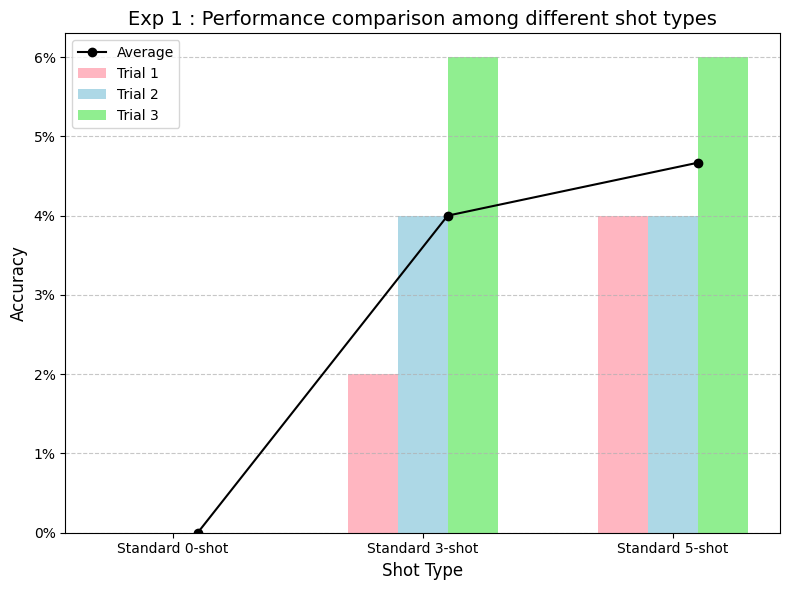

In [27]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Data
categories = ['Standard 0-shot', 'Standard 3-shot', 'Standard 5-shot']
trial_1 = [0.0, 0.02, 0.04]
trial_2 = [0.0, 0.04, 0.04]
trial_3 = [0.0, 0.06, 0.06]
averages = [0.0, 0.04, 0.04667]

# Convert values to percentages
trial_1_perc = [val * 100 for val in trial_1]
trial_2_perc = [val * 100 for val in trial_2]
trial_3_perc = [val * 100 for val in trial_3]
averages_perc = [val * 100 for val in averages]

# Pastel colors
pastel_colors = ['#FFB6C1', '#ADD8E6', '#90EE90']

# Plotting
bar_width = 0.2
index = range(len(categories))

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(index, trial_1_perc, bar_width, color=pastel_colors[0], label='Trial 1')
ax.bar([i + bar_width for i in index], trial_2_perc, bar_width, color=pastel_colors[1], label='Trial 2')
ax.bar([i + 2 * bar_width for i in index], trial_3_perc, bar_width, color=pastel_colors[2], label='Trial 3')
ax.plot([i + 1.5 * bar_width for i in index], averages_perc, marker='o', linestyle='-', color='black', label='Average')

ax.set_xlabel('Shot Type', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Exp 1 : Performance comparison among different shot types', fontsize=14)
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(categories)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Formatting y-axis ticks as percentages
def percentage(x, pos):
    return f'{x:.0f}%'

formatter = FuncFormatter(percentage)
ax.yaxis.set_major_formatter(formatter)

plt.tight_layout()

plt.show()





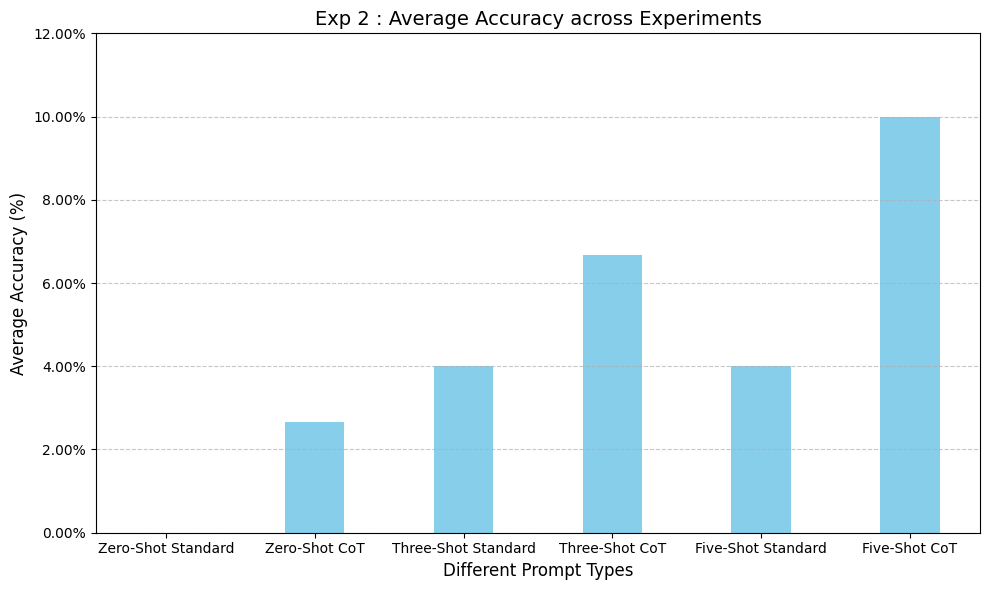

In [28]:
import matplotlib.pyplot as plt

# Data
experiments = ['Zero-Shot Standard', 'Zero-Shot CoT', 'Three-Shot Standard', 'Three-Shot CoT', 'Five-Shot Standard', 'Five-Shot CoT']
averages = [0.0, 0.0267, 0.04, 0.06667, 0.04, 0.1]  # Average values from Table 2, Table 3, and Table 4

# Multiply by 100 for percentage representation
averages_percent = [val * 100 for val in averages]

# Creating bar chart for average values
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.4
index = range(len(experiments))

ax.bar(experiments, averages_percent, bar_width, color='skyblue')

ax.set_xlabel('Different Prompt Types', fontsize=12)
ax.set_ylabel('Average Accuracy (%)', fontsize=12)
ax.set_title('Exp 2 : Average Accuracy across Experiments', fontsize=14)
ax.set_ylim(0, max(averages_percent) * 1.2)  # Adjusting y-axis limit for better visualization
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Formatting y-axis ticks as percentages
def percentage(x, pos):
    return f'{x:.2f}%'

formatter = plt.FuncFormatter(percentage)
ax.yaxis.set_major_formatter(formatter)

plt.tight_layout()

plt.show()


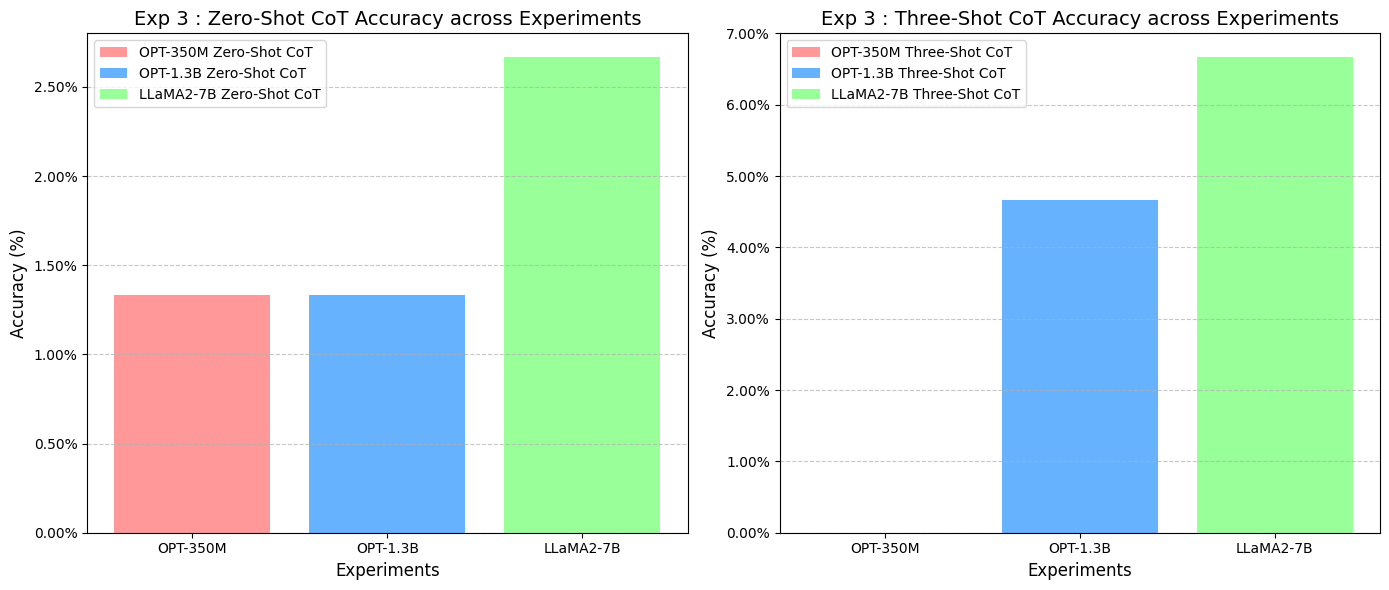

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Data
experiments = ['OPT-350M', 'OPT-1.3B', 'LLaMA2-7B']

# Accuracy values from Tables 5 and 6
values_zero_shot = [
    [0.0, 0.02, 0.02],
    [0.02, 0.0, 0.02],
    [0.04, 0.02, 0.02]
]

values_three_shot = [
    [0.0, 0.0, 0.0],
    [0.02, 0.1, 0.02],
    [0.12, 0.04, 0.04]
]

# Calculate averages for each group
averages_zero_shot = np.mean(values_zero_shot, axis=1)
averages_three_shot = np.mean(values_three_shot, axis=1)

# Multiply by 100 for percentage representation
values_zero_shot = np.array(values_zero_shot) * 100
values_three_shot = np.array(values_three_shot) * 100
averages_zero_shot *= 100
averages_three_shot *= 100

# Create pastel colors
pastel_colors = ['#FF9999', '#66B2FF', '#99FF99']

# Creating side-by-side bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Zero-Shot CoT accuracy
for i, exp in enumerate(experiments):
    ax1.bar(exp, averages_zero_shot[i], color=pastel_colors[i], label=f'{exp} Zero-Shot CoT')

ax1.set_xlabel('Experiments', fontsize=12)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Exp 3 : Zero-Shot CoT Accuracy across Experiments', fontsize=14)
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Formatting y-axis ticks as percentages
def percentage(x, pos):
    return f'{x:.2f}%'

formatter = plt.FuncFormatter(percentage)
ax1.yaxis.set_major_formatter(formatter)

# Three-Shot CoT accuracy
for i, exp in enumerate(experiments):
    ax2.bar(exp, averages_three_shot[i], color=pastel_colors[i], label=f'{exp} Three-Shot CoT')

ax2.set_xlabel('Experiments', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Exp 3 : Three-Shot CoT Accuracy across Experiments', fontsize=14)
ax2.legend()
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Formatting y-axis ticks as percentages
ax2.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()
